In [83]:
# @title **Importar dependencias**
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

In [5]:
import numpy as np
from PIL import Image
import os
import zipfile as zf

# Load the data
data = np.load("/content/olivetti_faces.npy.zip")
target = np.load("/content/olivetti_faces_target.npy")

# Extract the .npy file from the .zip
with zf.ZipFile("/content/olivetti_faces.npy.zip", 'r') as zip_ref:
    zip_ref.extractall('images')

data1 = np.load("/content/images/olivetti_faces.npy")

# Ensure the directory to save images exists
output_dir = "output_images_first_3_classes"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save images
for index, image_array in enumerate(data1):
    # Only save images for the first 3 classes (0, 1, 2)
    if target[index] > 3:
       break

    # Convert the numpy array to an image
    img = Image.fromarray((image_array * 255).astype(np.uint8))

    # Create a directory for the class if it doesn't exist
    class_dir = os.path.join(output_dir, str(target[index]))
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

    # Save the image to the corresponding class folder
    img_path = os.path.join(class_dir, f"image_{index}.png")
    img.save(img_path)

print("Images from the first 3 classes saved!")


Images from the first 3 classes saved!


In [6]:
from keras.preprocessing.image import ImageDataGenerator

img_size = (256, 256)
batch_size = 8
data_dir = "/content/output_images_first_3_classes"

# Data augmentation
train_datagen = ImageDataGenerator(
        validation_split=0.2,
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=60,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(
        validation_split=0.2)

# Data split Train and Validation
train_ds = train_datagen.flow_from_directory(
        data_dir,
        subset='training',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=42)

valid_ds = test_datagen.flow_from_directory(
        data_dir,
        subset='validation',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        seed=42)

class_names = list(train_ds.class_indices.keys())
print('Class names:', class_names)

Found 32 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Class names: ['0', '1', '2', '3']


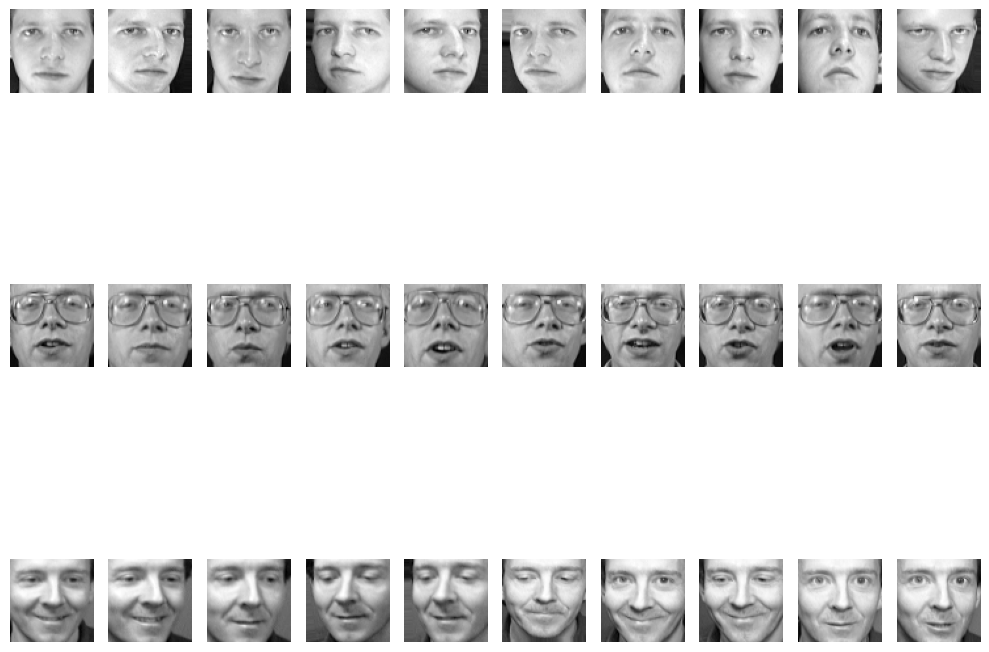

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile as zf

# Load the data
with zf.ZipFile("/content/olivetti_faces.npy.zip", 'r') as zip_ref:
    zip_ref.extractall('/content/')

data = np.load("/content/olivetti_faces.npy")
target = np.load("/content/olivetti_faces_target.npy")

# Set how many images per class you want to display
images_per_class = 10

# Find unique classes in the dataset
classes = np.unique(target)

# Set the figure size
plt.figure(figsize=(10, 10))

# We will only take the first 3 classes and display 10 images per class
for class_index in classes:
    if class_index > 2:  # We only want the first 3 classes
        break
    # Get the indices of images that belong to the current class
    indices = np.where(target == class_index)[0][:images_per_class]
    for i, img_index in enumerate(indices, start=1):
        # Calculate the position of the subplot
        plt.subplot(3, images_per_class, class_index * images_per_class + i)
        plt.imshow(data[img_index], cmap='gray')
        plt.axis('off')

# Adjust the layout of the plots
plt.tight_layout()
plt.show()


58889256/58889256 [==============================] - 0s 0us/step


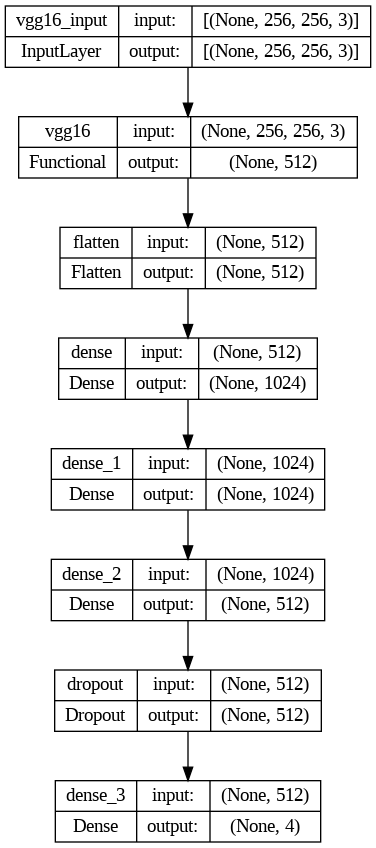

In [8]:
# @title **Importar modelo VGG16**

pretrained_model = keras.applications.VGG16(
  include_top=False,
  input_shape=img_size+(3,),  # Corrected input shape to match ResNet-50
  pooling='avg',
  classes=len(class_names),
  weights='imagenet')

# Transfer Learning
for layer in pretrained_model.layers:
  layer.trainable = False

model = Sequential()
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(class_names), activation='softmax'))
model.build(input_shape=img_size+(3,))

from keras.utils import plot_model
from keras.models import load_model  # Import your model

plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [10]:
epochs = 30
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max")

# Train the model with the callback
history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[checkpoint])

# Load the best model weights
model.load_weights("best_model.h5")

Epoch 1/30
4/4 [==============================] - 12s 271ms/step - loss: 3.9587 - accuracy: 0.2188 - val_loss: 3.1949 - val_accuracy: 0.2500
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 158ms/step - loss: 4.1255 - accuracy: 0.2188 - val_loss: 2.4542 - val_accuracy: 0.2500
Epoch 3/30
4/4 [==============================] - 1s 157ms/step - loss: 4.0006 - accuracy: 0.2188 - val_loss: 2.8638 - val_accuracy: 0.2500
Epoch 4/30
4/4 [==============================] - 1s 223ms/step - loss: 3.4778 - accuracy: 0.2812 - val_loss: 1.3177 - val_accuracy: 0.3750
Epoch 5/30
4/4 [==============================] - 1s 224ms/step - loss: 1.6930 - accuracy: 0.5312 - val_loss: 2.7597 - val_accuracy: 0.5000
Epoch 6/30
4/4 [==============================] - 1s 209ms/step - loss: 1.7920 - accuracy: 0.4688 - val_loss: 2.5645 - val_accuracy: 0.3750
Epoch 7/30
4/4 [==============================] - 1s 275ms/step - loss: 1.8191 - accuracy: 0.4375 - val_loss: 1.2680 - val_accuracy: 0.2500
Epoch 8/30
4/4 [==============================] - 1s 253ms/step - loss: 1.2964 - accuracy: 0.5938 - val_loss: 0.6645 - val_accuracy: 0.7500
Epoch 9/30
4/4 [===============

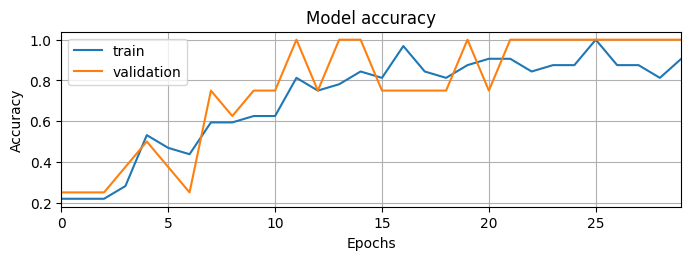

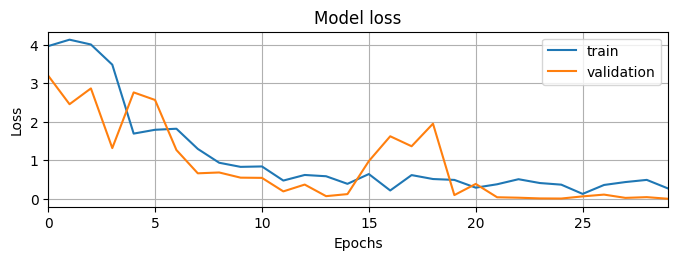

In [11]:
# @title **Visualización de resultados**

fig1 = plt.figure(figsize=(8, 5))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.axis(xmin=0,xmax=epochs-1)
plt.grid()
plt.show()

fig2 = plt.figure(figsize=(8, 5))
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.axis(xmin=0,xmax=epochs-1)
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import classification_report
import numpy as np

model = load_model("best_model.h5")
y_pred = []
y_true = []

batch_size = 7
random_indices = np.random.choice(len(valid_ds), size=batch_size)

for i in random_indices:
    X_batch, y_batch = valid_ds[i]
    batch_pred = model.predict(X_batch)
    y_pred.extend(np.argmax(batch_pred, axis=1))
    y_true.extend(np.argmax(y_batch, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 0s 23ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [84]:
def predecir_clase_de_imagen(image_path):
    # Carga la imagen
    img = image.load_img(image_path, target_size=img_size)

    # Preprocesa la imagen
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Añadir una dimensión para formar un lote de una sola imagen
    img = img / 255.0

    # Realiza la predicción
    predictions = model.predict(img)

    # Obtiene la clase predicha
    predicted_class = np.argmax(predictions)

    return class_names[predicted_class]

In [93]:
imagen_a_clasificar = input("Ingrese la ruta de la imagen de prueba: ")

# Realiza la predicción llamando a la función
clase_predicha = predecir_clase_de_imagen(imagen_a_clasificar)

# Imprime la clase predicha
print("Clase predicha:", clase_predicha)

Ingrese la ruta de la imagen de prueba: ejemplo2.png
1/1 [==============================] - 0s 18ms/step
Clase predicha: 2
